# The Hilbert Transform, Instantaneous Power/Phase, and Negative Frequencies in Neuroscience

If you work with oscillations in the brain, or any sort of time-frequency analysis of time series, you've probably used the Hilbert transform at some point. Depending on your background and level of comfort with signal processing, it may be just a scipy or MATLAB function call to you, or you might understand the theory behind it. What you might not appreciate, however, is one of the important assumptions behind it, specifically in the context of applying it to brain data. In particular, it's an important assumption in interpreting instantaneous oscillation power and phase in brain rhythms, especially if you've ever thought to yourself, "what does **instantaneous** power mean anyway?"

In the following post, I delve into the math behind the Hilbert Transform and provide some visualizations that will hopefully make these ideas clearer. When I was researching for this, seeing the complex vectors really helped me in understanding it better, as well as in seeing the elegance of the math. I will also clarify what scipy.signal.hilbert() is actually doing (hint: it's not computing the Hilbert Transform). You should have a basic exposure to frequency analysis and filtering, i.e. know what they do. But no more than that is necessary, as this post will unpack some fundamentals of Fourier Transform and complex sinusoids.

### The Hilbert Transform and instantaneous measures.

The Hilbert transform, in the most pragmatic sense, is a function that creates information. I know this sounds sacriligeous, but stay with me. If you read the docstring for scipy.signal.hilbert(), it says 

```
"Compute the analytic signal, using the Hilbert Transform".
```

In other words, it turns a real-valued signal into a complex-valued signal - it's analytic form - which means turning a 1-D time series (real) into a 2-D time series (real + imag). 

For purpose of demonstration, I will use a snippet of rat hippocampus local field potential data (courtesy of CRCNS, dataset hc2), because of its strong theta oscillation. The following few steps may be familiar to you, as I will first be filtering the raw signal for its theta component, then computing the Hilbert Transform.

In [161]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

plt.rcParams["axes.labelsize"]=20
plt.rcParams["font.size"]=15
plt.rcParams["font.family"] = "Arial"
from scipy import io, signal
import sys
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
from neurodsp import filter

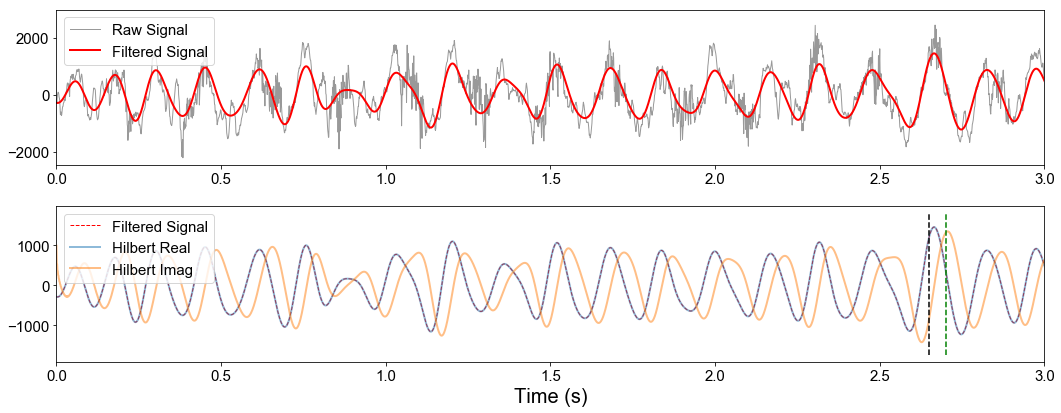

In [162]:
# loading the test data
data = io.loadmat('data/sample_data_2.mat', squeeze_me=True)
x = data['x'][:20000]
fs = data['fs']
t = np.arange(len(x))/fs

# filtering and hilbert transform
x_filt = filter(x, fs, 'bandpass', fc=(4,12), remove_edge_artifacts=False)
x_a = signal.hilbert(x_filt)

# plotting
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,x, 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,x_filt, 'r', label='Filtered Signal', lw=2)
plt.legend()
plt.xlim((0,3));

plt.subplot(2,1,2)
plt.plot(t,x_filt, '--r', label='Filtered Signal', alpha=1, lw=1)
plt.plot(t,x_a.real, label='Hilbert Real', alpha=0.5, lw=2)
plt.plot(t,x_a.imag, label='Hilbert Imag', alpha=0.5, lw=2)
plt.xlabel('Time (s)')
plt.legend(loc='upper left')
plt.xlim((0,3));

# selecting 2 slices of data
t1 = 2650
t2 = 2700
yb = plt.ylim()
plt.plot([t1/fs]*2, yb, 'k--')
plt.plot([t2/fs]*2, yb, 'g--')
plt.tight_layout()

In the first plot, you can see the raw hippocampus LFP (black) and the filtered theta component overlaid. If you comment on how non-sinusoidal the oscillation looks without provocation, your IP will be banned forever (joking but also don't). 

In the second plot are the filtered theta (dashed red), and the real (blue) and imaginary (orange) components of the analytic signal. Notice that the filtered signal and the real component of the analytic signal are completely overlapping, which is the first hint of what the Hilbert Transform does: it retrieves an imaginary component. This is what I meant by "creating information", but hold that protest still. 

Also, notice that the imaginary component is a) almost identical to, and b) slightly lagging the real component - by exactly 90 degrees, or pi/2 rad, in fact. At this point, those of you familiar with this analysis pipeline should anticipate the next few functions calls, which computes the "instantaneous" power and phase from the filtered theta signal.

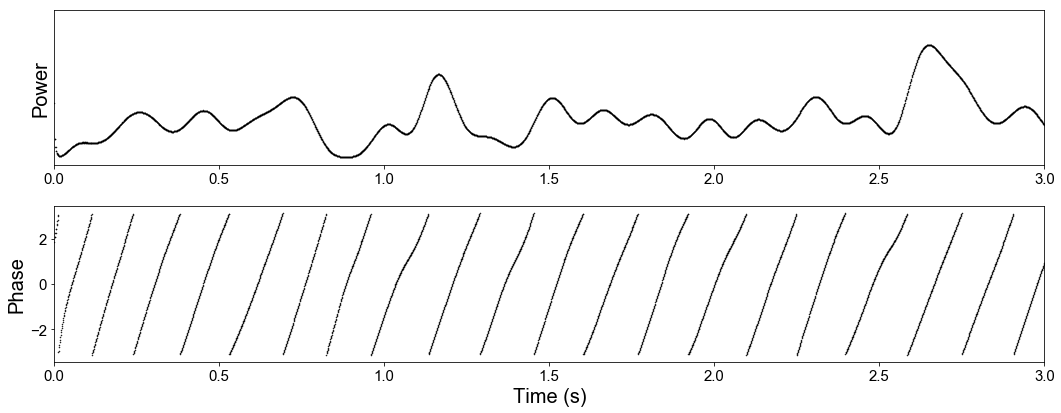

In [12]:
x_power = np.abs(x_a)**2
x_phase = np.angle(x_a)
# plotting
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,x_power, '.k', ms=1)
plt.yticks([])
plt.ylabel('Power')
plt.xlim((0,3));
plt.subplot(2,1,2)
plt.plot(t,x_phase, '.k', ms=1)
plt.ylabel('Phase')
plt.xlabel('Time (s)')
plt.xlim((0,3))
plt.tight_layout()

Having worked on these methods for some time now, I've sometimes felt an air of mysticism, and sometimes, skepticism, about how instantaneous measures could be computed on a signal. This is because I had an intuitive notion of what instantaneous amplitude (power) and phase are: amplitude is roughly the signal envelope of the sinusoid, and phase is the, well, phase of the sinusoid in that instant. 

Implictly, my notion of amplitude and phase is in accordance with the definition of a sinusoid as x(t) = Asin(wt+$\phi$), where A is the amplitude and $\phi$ is the phase lag. But given just a single point in a sinusoid-like real-valued signal, how does one decide what its instantaneous power is, if it's at any point in time other than the peak or trough, such as the two instants I've highlighted above in black and green?

But as you might have inferred from the above plots, that is actually a misconception. The instantaneous power is not computed on the filtered signal, but the analytic signal, which is the whole point of using the Hilbert Transform. Namely, it is the squared magnitude of the complex vector at an instant in time. Similarly, the instantaneous phase is the phase angle between the vector and the real axis (0 deg) in the complex plane. Mathematically, this refers to the complex sinusoid, i.e., x(t) = Ae^(iwt) in Euler form, or x(t) = A(cos(wt)+isin(wt)) in rectangular form.

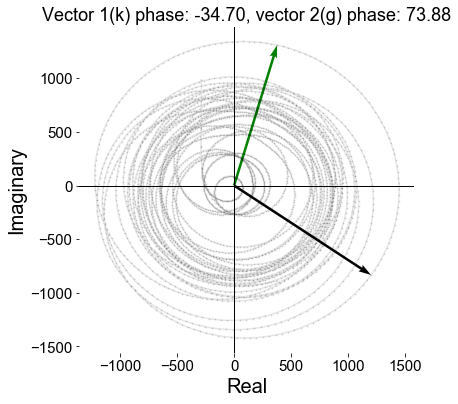

In [164]:
plt.figure(figsize=(6,6))
plt.axhline(color='k', lw=1)
plt.axvline(color='k', lw=1)
plt.plot(x_a.real[:5000],x_a.imag[:5000], 'k.-', alpha=0.1, ms=2)
plt.quiver(0,0,x_a[t1].real,x_a[t1].imag, angles='xy', scale_units='xy', scale=1, color='k')
plt.quiver(0,0,x_a[t2].real,x_a[t2].imag, angles='xy', scale_units='xy', scale=1, color='g')
plt.xlabel('Real');plt.ylabel('Imaginary')
plt.box('off')
plt.title('Vector 1(k) phase: %.2f, vector 2(g) phase: %.2f'%(x_phase[t1]/(2*np.pi)*360, x_phase[t2]/(2*np.pi)*360));

In the above plot, I've traced out the first 5 seconds of the analytic signal in the complex domain, where each small dot represents a vector in an instant in time (with its arrow-tail removed), and the black and green arrows refer to those two moments marked in dashed lines in the previous plot. What you can see is that the signal traces out a relatively smooth circular trajectory, with a varying radius. At any moment in time, the radius squared is the signal power, and its angle from the positive real line is the phase: so the black arrow is at about -30 degrees (or 330), and the green one at 75 degrees.

Hopefully, this clears up any confusion on how instantaneous power and phase are computed. I have to emphasize here that these are not mystical or vaguely intuitive measures at all, as I had thought, but mathematically well-defined quantities of every complex signal. Which now brings us back to the original question: how does the Hilbert Transform create the imaginary component of a real signal, out of thin air?

### Your Hilbert Transform is a lie.

To understand how the Hilbert Transform produces the analytic signal, we have to delve into the Fourier Transform and the (complex) sinusoidal bases. But first, a clarification. 

If you read through the [Wikipedia article on the Hilbert Transform](https://en.wikipedia.org/wiki/Hilbert_transform), it says: 

```
The Hilbert transform has a particularly simple representation in the frequency domain: it imparts a phase shift of 90° to every Fourier component of a function.
```

Technically, the Hilbert Transform as defined mathematically is not what scipy.signal.hilbert() or hilbert() in MATLAB does. What those functions do is to return the analytic signal, which is a complex signal defined as: 
x_a(t) = x(t) + iHT{x(t)} = Re(x_a(t)) + Im(x_a(t)). 

In other words, the mathematical Hilbert Transform produces the imaginary component of the analytic signal, which is not what scipy.signal.hilbert() returns. See the full documentation here:

![](data/2018-09-13-hilbert-scipy1.png)

(Ignore the middle part of that formula for now.)

The conflict is somewhat confusing, but was implemented as such probably because the HT is used almost exclusively in the context of computing the analytic signal. From this point on, I will be precise and use "analytic signal" for x_a(t), and "Hilbert Transform" (noun) for y=HT{x(t)} (note, without the 'i' attached), "Hilbert Transform" (verb) for the operation HT{ }, and hilbert() for the scipy function. This is the mathematically correct usage, but contradicts our everyday colloquial usage in neuroscience.

EDIT: it is at this point that I went back and changed all my variable names from x_ht to x_a. 

Noting the Wikipedia quote, this is consistent with what we saw in the second subpanel of the very first figure above: the imaginary component was about 90 degrees phase-lagged to the filtered theta oscillation. However, this is not always the case. Let's see what happens when we compute the analytic signal of the raw wideband signal.

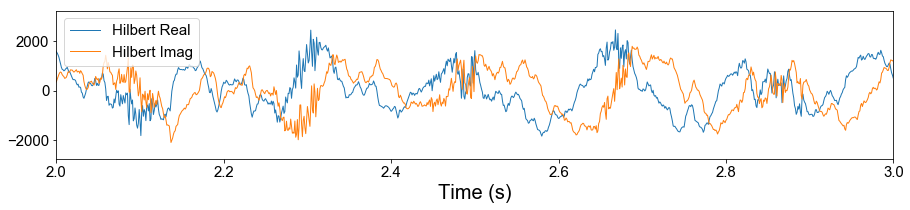

In [14]:
# plotting
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,signal.hilbert(x).real, label='Hilbert Real', lw=1)
plt.plot(t,signal.hilbert(x).imag, label='Hilbert Imag', lw=1)
plt.xlabel('Time (s)')
plt.legend()
plt.xlim((2,3));

I've zoomed in on a shorter segment of the signal for clarity. You can see that, roughly speaking, the imaginary component (orange) is still lagged about 90 deg compared to the real component, and this is due to the phase shift of the dominant theta frequency. However, it's not a literal time shift of the whole signal, since many of the more squiggly high-frequency ripple components are not exactly copied over but remain in the same theta phase (e.g., see ripple at 2.3s). As the Wikipedia article states, the Hilbert transform imparts a 90 degrees phase shift to **every** Fourier component, not just the strongest (theta) component. In other words, every complex Fourier coefficient in the raw broadband signal is delayed by 90 degrees.

Why does introducing a 90-degree lag produce the imaginary component of the signal? Finally, we are ready for the part that I enjoy the most: the relationship between the Hilbert Transform and the Fourier Transform, in vectors. Bonus, we make our own DIY Hilbert Transform.

### Negative Frequencies

Going back to the beginning of the tutorial, I mentioned that the Hilbert Transform creates information, which is in the form of the imaginary component of the analytic signal. That's actually a lie. From the perspective of the time-domain signal, indeed, it seems to have generated a 2-dimensional (complex) signal from a 1-dimensional (real scalar) signal. The information it "creates", however, comes from a specific assumption, and when viewed in the frequency (or Fourier) domain, it's actually not creating information at all, but splitting the original signal in two. I will illustrate this with a perfect sine wave first.

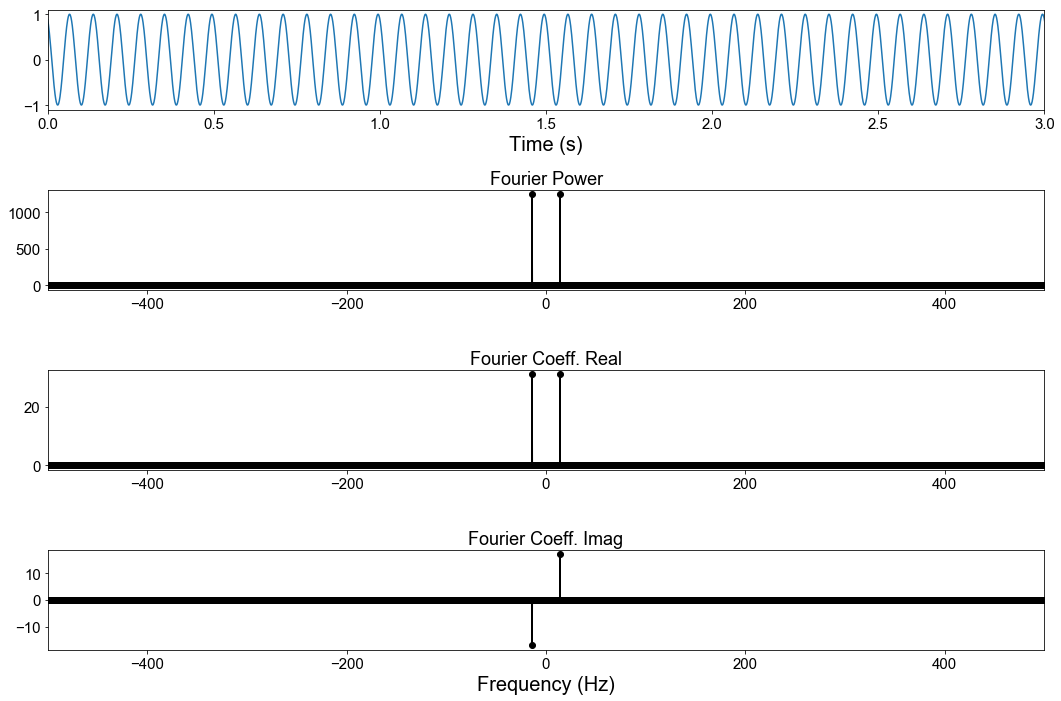

In [91]:
# create a sine wave for 5 seconds at 14Hz, with slight phase delay
t_trunc = t[:5000]
x_sin = np.cos(2*np.pi*14*t_trunc+0.5)
F_sin = np.fft.fft(x_sin, norm='ortho')
f_axis = np.fft.fftfreq(len(x_sin),1/fs)

plt.figure(figsize=(15,10))
# time domain plot
plt.subplot(4,1,1)
plt.plot(t_trunc,x_sin)
plt.xlabel('Time (s)')
plt.xlim((0,3))


# frequency domain plots
plt.subplot(4,1,2)
plt.plot(f_axis, np.abs(F_sin)**2,'ko-')
plt.title('Fourier Power')
plt.xlim([-500,500])
plt.subplot(4,1,3)
plt.plot(f_axis, F_sin.real, 'ko-')
plt.title('Fourier Coeff. Real')
plt.xlim([-500,500])
plt.subplot(4,1,4)
plt.plot(f_axis, F_sin.imag, 'ko-', label='Fourier Imag')
plt.title('Fourier Coeff. Imag')
plt.xlim([-500,500])
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

The first plot shows the sine wave in time domain, and the next three show the Fourier power (squared amplitude), as well as the real and imaginary components of the Fourier coefficients. A few things will jump out at you. First, Fourier power is zero everywhere except two points, which are at 14 and -14 Hz. In neuroscience, it's almost always the case that power spectra are plotted with only the positive frequencies, i.e., the right half. This is because for any real-valued signal, as all brain recordings are, the power spectrum is symmetrical about 0Hz, so plotting the left side is just wasting space. But somtimes we're so used to looking at the positive half of the spectrum that we forget the other half exists, or matters at all.

Here's why it matters. The 14 Hz power we see **does not** represent the squared magnitude of our scalar sinusoid at f=14 Hz, i.e. x(t) = cos($2\pi$ft), which one might assume by looking just at the positive frequencies. Instead, it's the squared magnitude of the **complex sinusoid** at 14 Hz, in the form of z(t) = Aexp(i$2\pi$ft). This is because the basis functions for Fourier decomposition are not real sinusoids, but complex sinusoids. 

This is getting a little gnarly, so I think you'll like this next part. In rectangular form, the complex sinusoid looks like z(t) = Acos($2\pi$ft) + iAsin($2\pi$ft). Wait a minute, that's just our original signal (cos($2\pi$ft)) with an unwanted imaginary part tacked onto the end! The original signal is purely real, so how do we get rid of this imaginary sine component? The answer is in the negative frequency. Specifically, at -14Hz.

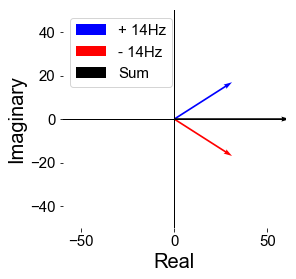

In [116]:
fc_pos = F_sin[np.where(f_axis==14)[0]][0]
fc_neg = F_sin[np.where(f_axis==-14)[0]][0]
plt.figure(figsize=(4,4))
plt.axhline(color='k', lw=1)
plt.axvline(color='k', lw=1)
plt.quiver(0,0,fc_pos.real,fc_pos.imag, angles='xy', scale_units='xy', scale=1, label='+ 14Hz', color='b')
plt.quiver(0,0,fc_neg.real,fc_neg.imag, angles='xy', scale_units='xy', scale=1, label='- 14Hz', color='r')
plt.quiver(0,0,(fc_pos+fc_neg).real,(fc_pos+fc_neg).imag, angles='xy', scale_units='xy', scale=1, label='Sum', color='k')
plt.legend(loc='upper left')
plt.xlim((-60,60)); plt.ylim((-50,50))
plt.xlabel('Real');plt.ylabel('Imaginary')
plt.box('off')

The three vectors above represent the complex sinusoids at 14Hz (blue) and -14Hz (red) in the complex plane, and their vector sum (black). They're not exactly like the black and green ones from a few plots above. Those previous ones represent two instants of the same complex sinusoidal function as it evolves in time, while these represent two complex sinusoids extracted from our made up signal, and their sum. There is one thing in common, however, which is that you could imagine the blue and red vectors here rotating about the origin as progression of time, which corresponds to phase advancing the time series. The only extra rule is that the **blue vector rotates counterclockwise**, since it's a positive frequency, and **the red vector rotates clockwise but at the same speed** (their frequency (14Hz) in radians).

It's no coincidence that the negative frequency vector is reflected about the real axis from the positive frequency - this is how the imaginary component is cancelled out to form our real-value only signal. Since the two colored vectors always mirror each other about the real axis as they rotate, their summation (black vector) will **always** fall exactly onto the real axis. As the colored vectors rotate about, the black vectors will shrink and grow, representing the value of the real sinusoidal function in time.

In math, this cancellation of imaginary components amounts to:
z(t) + z'(t) = A(cos($2\pi$ft) + isin($2\pi$ft)) + A(cos($2\pi$ft) - isin($2\pi$ft)) = 2Acos($2\pi$ft) = 2Ax(t)

and thus, we get back our signal (with a scaling constant of A=1/2 on the complex sinusoids). To further verify that this is accurate, we can check that the energy from the two sinusoids sum to be equal to the energy of the time series, which is just the sum of squares in this case (Parseval's theorem).

In [121]:
print('Signal energy=%.2f, Fourier energy=%.2f'%(np.sum(x_sin**2), np.abs(fc_pos)**2+np.abs(fc_neg)**2)) 

Signal energy=2500.00, Fourier energy=2500.00


### Hilbert Transform, revisted.

Armed with the concept of negative frequencies, let's work out what the Hilbert Transform should be doing. Following the perfect sinusoid example, the goal is to transform x(t) = cos($2\pi$ft) to its analytic signal, x_a(t) = x(t) + iy(t) = cos($2\pi$ft) + isin($2\pi$ft). Graphically, this amounts to getting the blue vector from the black vector. Without looking at the math, we should have an idea of what to do here, given the forward steps we took from the blue and red vector to the black vector - we simply need to erase the red vector and multiply the blue vector by 2. Turns out, this is exactly what scipy.signal.hilbert() does:

![](data/2018-09-13-hilbert-scipy2.png)

Briefly, the positive step function U retains the positive frequencies of the Fourier Transform, while multiplying by 2.

"The negative half of the frequency spectrum is zeroes out." In other words, deleting the negative frequency complex sinusoid(s) transforms the real-valued signal to the analytic signal. I thought this shortcut is honestly pretty cool, and makes a lot more sense after understanding the geometrical interpretation of the negative frequency sinusoids. Also, this probably points to the real reason for implementing scipy.signal.hilbert() as getting the analytic signal directly - it's a lot easier than getting the actual Hilbert Transform.

Finally, let's see if we can implement our own Hilbert Transform function by following these steps, with the **correct** name.

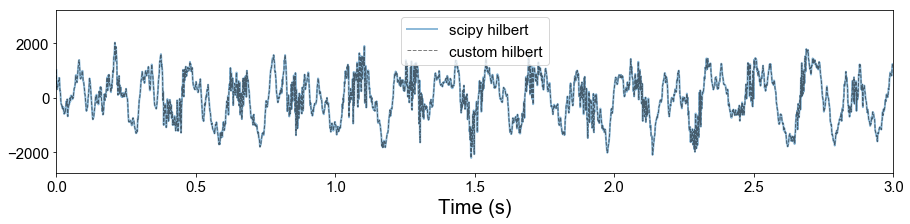

In [149]:
def analytical_sig(x):
    Fx = np.fft.fft(x) # get fft
    f_axis = np.fft.fftfreq(len(x)) 
    Fx[np.where(f_axis<0)]=0. # zero out negative frequencies
    return np.fft.ifft(Fx*2) # return 2x positive frequencies

x_a = signal.hilbert(x)
x_a2 = analytical_sig(x)
plt.figure(figsize=(15,3))
plt.plot(t,x_a.imag, alpha=0.5, label='scipy hilbert', lw=2)
plt.plot(t,x_a2.imag, 'k--', alpha=0.5, label='custom hilbert', lw=1)
plt.xlim((0,3))
plt.xlabel('Time (s)')
plt.legend()

Perfect overlap, and that is all. I hope this provided some intuition for what the Hilbert Transform is doing, as well as an explanation of what instantaneous power/phase is in brain signals. 

### Some last thoughts:
- Remember that x_a(t) = x(t) + jHT{x(t)}, so how do we actually compute the Hilbert Transform without going directly to the analytic signal, and how does the Hilbert Transform negate the negative frequency component? This [tutorial][1] does an in-depth explanation, which has some really simple but elegant complex math, as well as neat visualizations that should be accessible if you've been following up to this point.


- I think it's hilarious that scipy.signal.hilbert() not only does not return the Hilbert Transform, as its function name would suggest, it doesn't even compute the Hilbert Transform at all. The last part of the docstring basically says you can GET the Hilbert Transform of the signal yourself if you want to, by just taking the imaginary component, but why would you want to? There's gotta be a joke about programmers and engineers being practical here.


- I had a misconception that the Hilbert Transform only "existed" for narrowband signals. This is not true, as we clearly demonstrated above. HT is a well defined mathematical operation regardless of the bandwidth of the signal. The issue here is more so in the context of neuroscientific data, i.e., how to interpret the Hilbert Transform of a signal that doesn't have a dominant oscillatory mode, specifically its instantaneous phase. If we are not careful here and just apply the method, we can extract a phase time series for all signals, but may or may not be valid. This gets at the broader question of bandpassing a signal for an oscillatory component when there is none, but that's discussion for another day.


- Actually, I will just say one more thing about that, and this is worth **emphasizing**. There is a fine but ideological difference between generative model and descriptive analysis. Using Fourier analysis to compute the band-limited energy does not mean you subscribe to the model that the signal is generated by sinusoids, as its simply a description (or representation) of the signal. The time series itself is another representation - you can represent that same signal in infinitely many ways. Using the Hilbert Transform is also not subscribing to a particular generative model - you don't have to presume a complex sinusoidal generator to describe it as one. However, there is a fine line you cross when you interpret the transformed representations as being generated by an implicit model, like claiming the band-limited phase time series as the phase of a sole oscillator at that frequency. This does subscribe to the model that there **is** an underlying oscillator in the signal, which is not at all implied by the descriptive analysis. Fourier analysis is very useful in many aspects, especially sparse representation of oscillatory signals. But it's not as useful in faithfully (and sparsely) describing non-sinusoidal oscillations and non-oscillatory phenomena.


- I've never used complex sinusoidal or wavelet filters, only real-valued ones. I would imagine, given the above, that filtering with a complex wavelet bypasses the need to apply the Hilbert Transform, since it's, in a sense, transformed (into the complex time series) as it is filtered.

### Sources:
[1]:https://ccrma.stanford.edu/~jos/mdft/Analytic_Signals_Hilbert_Transform.html
[Phase Quadrature](https://ccrma.stanford.edu/~jos/mdft/Analytic_Signals_Hilbert_Transform.html)
[Complex Sinusoids](https://www.dsprelated.com/freebooks/filters/Plotting_Complex_Sinusoids_Circular.html)
[Symmetry](https://www.dsprelated.com/freebooks/mdft/Symmetry.html)
[Mike X Cohen lecture](https://www.youtube.com/watch?list=PLn0OLiymPak3jjr0hHI9OFXuQyPBQlFdk&v=VyLU8hlhI-I)
[scipy doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html)
[Wikipedia](https://en.wikipedia.org/wiki/Hilbert_transform)